# 実験2B：実世界HPO問題での評価実験

この実験では、LinBandit-BOを実際の機械学習モデルのハイパーパラメータ最適化（HPO）問題で評価します。

## 対象モデル：
1. **XGBoost** (勾配ブースティング)
2. **Random Forest** (ランダムフォレスト)
3. **SVM** (サポートベクターマシン)
4. **Neural Network** (ニューラルネットワーク)

## データセット：
- Scikit-learnの標準的なベンチマークデータセット
- 分類タスクと回帰タスクの両方を含む

## 比較対象：
1. LinBandit-BO
2. TuRBO
3. Vanilla BO
4. Random Search

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# BoTorch imports
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from torch.quasirandom import SobolEngine

# ML imports
from sklearn.datasets import load_digits, load_wine, load_breast_cancer, fetch_california_housing
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
import xgboost as xgb

# デフォルトのdtypeをfloat32に設定
torch.set_default_dtype(torch.float32)

# プロット設定
plt.rcParams["figure.dpi"] = 100
plt.rcParams['figure.figsize'] = (12, 8)

# 日本語フォント設定
try:
    import japanize_matplotlib
except ImportError:
    import matplotlib
    if os.name == 'nt':
        plt.rcParams['font.family'] = ['MS Gothic', 'Yu Gothic', 'Meiryo']
    elif os.uname().sysname == 'Darwin':
        plt.rcParams['font.family'] = ['Hiragino Sans', 'Hiragino Maru Gothic Pro']
    else:
        plt.rcParams['font.family'] = ['IPAGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP', 'TakaoGothic']
    plt.rcParams['axes.unicode_minus'] = False

# 出力フォルダの作成
output_dir = "output_results_hpo_benchmark"
os.makedirs(output_dir, exist_ok=True)

print("実験環境の設定完了")

実験環境の設定完了


In [2]:
# HPOベンチマーク問題の定義
class HPOBenchmark:
    """実世界のHPO問題をベンチマークとして定義"""
    
    def __init__(self, model_type, dataset_name, task_type='classification'):
        self.model_type = model_type
        self.dataset_name = dataset_name
        self.task_type = task_type
        self.cv_folds = 3  # 計算時間削減のため3-fold CV
        self.eval_count = 0
        
        # データセットの読み込み
        self.load_dataset()
        
        # ハイパーパラメータ空間の定義
        self.define_hyperparameter_space()
        
    def load_dataset(self):
        """データセットの読み込みと前処理"""
        if self.dataset_name == 'digits':
            data = load_digits()
        elif self.dataset_name == 'wine':
            data = load_wine()
        elif self.dataset_name == 'breast_cancer':
            data = load_breast_cancer()
        elif self.dataset_name == 'california_housing':
            data = fetch_california_housing()
            self.task_type = 'regression'
        else:
            raise ValueError(f"Unknown dataset: {self.dataset_name}")
            
        self.X = data.data
        self.y = data.target
        
        # データの正規化
        scaler = StandardScaler()
        self.X = scaler.fit_transform(self.X)
        
    def define_hyperparameter_space(self):
        """各モデルのハイパーパラメータ空間を定義"""
        if self.model_type == 'xgboost':
            # XGBoostのハイパーパラメータ
            self.param_names = ['n_estimators', 'max_depth', 'learning_rate', 
                               'subsample', 'colsample_bytree', 'gamma']
            self.param_bounds = torch.tensor([
                [10, 300],      # n_estimators
                [1, 10],        # max_depth
                [0.01, 1.0],    # learning_rate (log scale)
                [0.5, 1.0],     # subsample
                [0.5, 1.0],     # colsample_bytree
                [0.0, 1.0]      # gamma
            ], dtype=torch.float32).T
            self.log_scale_params = [2]  # learning_rate
            
        elif self.model_type == 'random_forest':
            # Random Forestのハイパーパラメータ
            self.param_names = ['n_estimators', 'max_depth', 'min_samples_split', 
                               'min_samples_leaf', 'max_features']
            self.param_bounds = torch.tensor([
                [10, 300],      # n_estimators
                [1, 30],        # max_depth
                [2, 20],        # min_samples_split
                [1, 20],        # min_samples_leaf
                [0.1, 1.0]      # max_features
            ], dtype=torch.float32).T
            self.log_scale_params = []
            
        elif self.model_type == 'svm':
            # SVMのハイパーパラメータ
            self.param_names = ['C', 'gamma']
            self.param_bounds = torch.tensor([
                [0.001, 1000],  # C (log scale)
                [0.001, 10]     # gamma (log scale)
            ], dtype=torch.float32).T
            self.log_scale_params = [0, 1]
            
        elif self.model_type == 'neural_network':
            # Neural Networkのハイパーパラメータ
            self.param_names = ['hidden_layer_1', 'hidden_layer_2', 'learning_rate', 
                               'alpha', 'batch_size']
            self.param_bounds = torch.tensor([
                [10, 200],      # hidden_layer_1
                [10, 200],      # hidden_layer_2
                [0.0001, 0.1],  # learning_rate (log scale)
                [0.0001, 0.1],  # alpha (log scale)
                [16, 256]       # batch_size
            ], dtype=torch.float32).T
            self.log_scale_params = [2, 3]
            
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")
            
        self.dim = len(self.param_names)
        
    def params_to_dict(self, x):
        """パラメータベクトルを辞書形式に変換"""
        if torch.is_tensor(x):
            x = x.cpu().numpy()
            
        params = {}
        for i, name in enumerate(self.param_names):
            val = x[i] if x.ndim == 1 else x[:, i]
            
            # ログスケールの変換
            if i in self.log_scale_params:
                val = 10 ** val
                
            # 整数パラメータの処理
            if name in ['n_estimators', 'max_depth', 'min_samples_split', 
                       'min_samples_leaf', 'hidden_layer_1', 'hidden_layer_2', 'batch_size']:
                val = int(val)
                
            params[name] = val
            
        return params
    
    def objective_function(self, x):
        """目的関数：交差検証スコア（最小化問題として）"""
        self.eval_count += 1
        
        if x.ndim == 2:
            # バッチ評価
            scores = []
            for i in range(x.shape[0]):
                score = self._evaluate_single(x[i])
                scores.append(score)
            return torch.tensor(scores, dtype=torch.float32)
        else:
            # 単一評価
            score = self._evaluate_single(x)
            return torch.tensor(score, dtype=torch.float32)
            
    def _evaluate_single(self, x):
        """単一のハイパーパラメータ設定を評価"""
        params = self.params_to_dict(x)
        
        try:
            if self.model_type == 'xgboost':
                if self.task_type == 'classification':
                    model = xgb.XGBClassifier(**params, use_label_encoder=False, 
                                            eval_metric='logloss', random_state=42)
                else:
                    model = xgb.XGBRegressor(**params, random_state=42)
                    
            elif self.model_type == 'random_forest':
                if self.task_type == 'classification':
                    model = RandomForestClassifier(**params, random_state=42)
                else:
                    model = RandomForestRegressor(**params, random_state=42)
                    
            elif self.model_type == 'svm':
                if self.task_type == 'classification':
                    model = SVC(**params, random_state=42)
                else:
                    model = SVR(**params)
                    
            elif self.model_type == 'neural_network':
                hidden_layers = (params['hidden_layer_1'], params['hidden_layer_2'])
                if self.task_type == 'classification':
                    model = MLPClassifier(
                        hidden_layer_sizes=hidden_layers,
                        learning_rate_init=params['learning_rate'],
                        alpha=params['alpha'],
                        batch_size=params['batch_size'],
                        max_iter=100,
                        random_state=42
                    )
                else:
                    model = MLPRegressor(
                        hidden_layer_sizes=hidden_layers,
                        learning_rate_init=params['learning_rate'],
                        alpha=params['alpha'],
                        batch_size=params['batch_size'],
                        max_iter=100,
                        random_state=42
                    )
                    
            # 交差検証スコアの計算
            cv = KFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
            if self.task_type == 'classification':
                scores = cross_val_score(model, self.X, self.y, cv=cv, scoring='accuracy')
            else:
                scores = cross_val_score(model, self.X, self.y, cv=cv, scoring='r2')
                
            # 負の平均スコアを返す（最小化問題として）
            return -scores.mean()
            
        except Exception as e:
            # エラーが発生した場合は最悪のスコアを返す
            print(f"Error in evaluation: {e}")
            return 1.0

print("HPOベンチマーククラスの定義完了")

HPOベンチマーククラスの定義完了


In [3]:
# LinBandit-BO実装（最適化版）
class LinBanditBO:
    def __init__(self, objective_function, bounds, n_initial=5, n_max=100, 
                 coordinate_ratio=0.8, n_arms=None):
        self.objective_function = objective_function
        self.bounds = bounds.float()
        self.dim = bounds.shape[1]
        self.n_initial = n_initial
        self.n_max = n_max
        self.coordinate_ratio = coordinate_ratio
        
        # 0.5x arms設定
        self.n_arms = n_arms if n_arms is not None else max(1, self.dim // 2)
        
        # Linear Banditのパラメータ
        self.A = torch.eye(self.dim)
        self.b = torch.zeros(self.dim)
        
        # 初期点の生成
        self.X = torch.rand(n_initial, self.dim) * (bounds[1] - bounds[0]) + bounds[0]
        self.X = self.X.float()
        
        # 状態変数
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []
        self.theta_history = []
        self.scale_init = 1.0
        self.total_iterations = 0
        
    def update_model(self):
        kernel = ScaleKernel(
            RBFKernel(ard_num_dims=self.X.shape[-1], dtype=torch.float32),
            dtype=torch.float32
        ).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)
        
    def initialize(self):
        y_val = self.objective_function(self.X)
        self.Y = y_val.unsqueeze(-1).float()
        
        y_max, y_min = self.Y.max().item(), self.Y.min().item()
        self.scale_init = (y_max - y_min) if (y_max - y_min) != 0 else 1.0
        
        self.update_model()
        
        post_mean = self.model.posterior(self.X).mean.squeeze(-1)
        bi = post_mean.argmin()
        self.best_value = post_mean[bi].item()
        self.best_point = self.X[bi]
        self.eval_history = [self.best_value] * self.n_initial
        
    def generate_arms(self):
        num_coord = int(self.coordinate_ratio * self.n_arms)
        num_coord = min(num_coord, self.dim)
        
        idxs = np.random.choice(self.dim, num_coord, replace=False)
        
        coords = []
        for i in idxs:
            e = torch.zeros(self.dim, device=self.X.device)
            e[i] = 1.0
            coords.append(e)
            
        coord_arms = torch.stack(coords, 0) if coords else torch.zeros(0, self.dim, device=self.X.device)
        
        num_rand = self.n_arms - num_coord
        rand_arms = torch.randn(num_rand, self.dim, device=self.X.device) if num_rand > 0 else torch.zeros(0, self.dim, device=self.X.device)
        
        if num_rand > 0:
            norms = rand_arms.norm(dim=1, keepdim=True)
            rand_arms = torch.where(norms > 1e-9, rand_arms / norms, 
                                   torch.randn_like(rand_arms) / (torch.randn_like(rand_arms).norm(dim=1,keepdim=True)+1e-9))
            
        return torch.cat([coord_arms, rand_arms], 0)
    
    def select_arm(self, arms_features):
        sigma = 1.0
        L = 1.0
        lambda_reg = 1.0
        delta = 0.1
        S = 1.0
        
        A_inv = torch.inverse(self.A)
        theta = A_inv @ self.b
        self.theta_history.append(theta.clone())
        
        current_round_t = max(1, self.total_iterations)
        log_term_numerator = max(1e-9, 1 + (current_round_t - 1) * L**2 / lambda_reg)
        beta_t = (sigma * math.sqrt(self.dim * math.log(log_term_numerator / delta)) + 
                  math.sqrt(lambda_reg) * S)
        
        ucb_scores = []
        for i in range(arms_features.shape[0]):
            x = arms_features[i].view(-1, 1)
            mean = (theta.view(1, -1) @ x).item()
            try:
                var = (x.t() @ A_inv @ x).item()
            except torch.linalg.LinAlgError:
                var = (x.t() @ torch.linalg.pinv(self.A) @ x).item()
                
            ucb_scores.append(mean + beta_t * math.sqrt(max(var, 0)))
            
        return int(np.argmax(ucb_scores))
    
    def propose_new_x(self, direction):
        ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)
        
        active_dims_mask = direction.abs() > 1e-9
        if not active_dims_mask.any():
            lb, ub = -1.0, 1.0
        else:
            ratios_lower = (self.bounds[0] - self.best_point) / (direction + 1e-12 * (~active_dims_mask))
            ratios_upper = (self.bounds[1] - self.best_point) / (direction + 1e-12 * (~active_dims_mask))
            
            t_bounds = torch.zeros(self.dim, 2, device=self.X.device)
            t_bounds[:, 0] = torch.minimum(ratios_lower, ratios_upper)
            t_bounds[:, 1] = torch.maximum(ratios_lower, ratios_upper)
            
            lb = -float('inf')
            ub = float('inf')
            for i in range(self.dim):
                if active_dims_mask[i]:
                    lb = max(lb, t_bounds[i, 0].item())
                    ub = min(ub, t_bounds[i, 1].item())
                    
        if lb > ub:
            domain_width = (self.bounds[1, 0] - self.bounds[0, 0]).item()
            lb = -0.1 * domain_width
            ub = 0.1 * domain_width
            
        one_d_bounds = torch.tensor([[lb], [ub]], dtype=torch.float32, device=self.X.device)
        
        def ei_on_line(t_scalar_tensor):
            t_values = t_scalar_tensor.squeeze(-1)
            points_on_line = self.best_point.unsqueeze(0) + t_values.reshape(-1, 1) * direction.unsqueeze(0)
            points_on_line_clamped = torch.clamp(points_on_line, self.bounds[0].unsqueeze(0), self.bounds[1].unsqueeze(0))
            return ei(points_on_line_clamped.unsqueeze(1))
        
        cand_t, _ = optimize_acqf(
            ei_on_line,
            bounds=one_d_bounds,
            q=1,
            num_restarts=10,
            raw_samples=100
        )
        
        alpha_star = cand_t.item()
        new_x = self.best_point + alpha_star * direction
        new_x_clamped = torch.clamp(new_x, self.bounds[0], self.bounds[1])
        
        return new_x_clamped
    
    def optimize(self):
        self.initialize()
        n_iter = self.n_initial
        
        while n_iter < self.n_max:
            self.total_iterations += 1
            
            arms_features = self.generate_arms()
            sel_idx = self.select_arm(arms_features)
            direction = arms_features[sel_idx]
            
            new_x = self.propose_new_x(direction)
            
            with torch.no_grad():
                predicted_mean = self.model.posterior(new_x.unsqueeze(0)).mean.squeeze().item()
            actual_y = self.objective_function(new_x.unsqueeze(0)).squeeze().item()
            
            # 勾配ベース報酬
            new_x_for_grad = new_x.clone().unsqueeze(0)
            new_x_for_grad.requires_grad_(True)
            
            posterior = self.model.posterior(new_x_for_grad)
            mean_at_new_x = posterior.mean
            
            mean_at_new_x.sum().backward()
            grad_vector = new_x_for_grad.grad.squeeze(0)
            
            reward_vector = grad_vector.abs()
            
            x_arm = direction.view(-1, 1)
            self.A += x_arm @ x_arm.t()
            self.b += reward_vector
            
            self.X = torch.cat([self.X, new_x.unsqueeze(0)], 0)
            self.Y = torch.cat([self.Y, torch.tensor([[actual_y]], dtype=torch.float32, device=self.X.device)], 0)
            self.update_model()
            
            with torch.no_grad():
                posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
            current_best_idx = posterior_mean.argmin()
            self.best_value = posterior_mean[current_best_idx].item()
            self.best_point = self.X[current_best_idx]
            
            self.eval_history.append(self.best_value)
            n_iter += 1
                
        return self.best_point, self.best_value

print("LinBandit-BOクラスの定義完了")

LinBandit-BOクラスの定義完了


In [4]:
# 他のアルゴリズムの実装（TuRBO、Vanilla BO、Random Search）
# ※実験1と同じ実装なので省略

# TuRBO実装（簡略版）
class TuRBO:
    def __init__(self, objective_function, bounds, n_initial=5, n_max=100,
                 n_trust_regions=1, length_init=0.8, length_min=0.5**7,
                 length_max=1.6, failure_tolerance=5, success_tolerance=3):
        self.objective_function = objective_function
        self.bounds = bounds.float()
        self.dim = bounds.shape[1]
        self.n_initial = n_initial
        self.n_max = n_max
        self.n_trust_regions = n_trust_regions
        
        self.length = length_init
        self.length_init = length_init
        self.length_min = length_min
        self.length_max = length_max
        self.failure_tolerance = failure_tolerance
        self.success_tolerance = success_tolerance
        
        sobol = SobolEngine(dimension=self.dim, scramble=True)
        self.X = sobol.draw(n=n_initial).to(dtype=torch.float32)
        self.X = self.X * (bounds[1] - bounds[0]) + bounds[0]
        
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []
        
        self.successes = 0
        self.failures = 0
        
    def update_model(self):
        X_normalized = normalize(self.X, self.bounds)
        Y_normalized = (self.Y - self.Y.mean()) / (self.Y.std() + 1e-6)
        
        kernel = ScaleKernel(
            RBFKernel(ard_num_dims=self.dim, dtype=torch.float32),
            dtype=torch.float32
        )
        self.model = SingleTaskGP(X_normalized, Y_normalized, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)
        
    def initialize(self):
        y_val = self.objective_function(self.X)
        self.Y = y_val.unsqueeze(-1).float()
        
        self.update_model()
        
        best_idx = self.Y.argmin()
        self.best_value = self.Y[best_idx].item()
        self.best_point = self.X[best_idx]
        self.eval_history = [self.best_value] * self.n_initial
        
    def create_candidate(self):
        x_center = normalize(self.best_point.unsqueeze(0), self.bounds)
        
        tr_lb = torch.clamp(x_center - self.length / 2.0, 0.0, 1.0)
        tr_ub = torch.clamp(x_center + self.length / 2.0, 0.0, 1.0)
        
        ucb = UpperConfidenceBound(self.model, beta=2.0, maximize=False)
        
        candidate, _ = optimize_acqf(
            acq_function=ucb,
            bounds=torch.stack([tr_lb.squeeze(), tr_ub.squeeze()]),
            q=1,
            num_restarts=10,
            raw_samples=512,
        )
        
        candidate = unnormalize(candidate, self.bounds)
        
        return candidate.squeeze(0)
    
    def update_trust_region(self, y_new):
        if y_new < self.best_value:
            self.successes += 1
            self.failures = 0
        else:
            self.successes = 0
            self.failures += 1
            
        if self.failures >= self.failure_tolerance:
            self.length = max(self.length / 2.0, self.length_min)
            self.failures = 0
        elif self.successes >= self.success_tolerance:
            self.length = min(self.length * 2.0, self.length_max)
            self.successes = 0
            
    def optimize(self):
        self.initialize()
        n_iter = self.n_initial
        
        pbar = tqdm(total=self.n_max - self.n_initial, desc="TuRBO")
        
        while n_iter < self.n_max:
            new_x = self.create_candidate()
            new_y = self.objective_function(new_x.unsqueeze(0)).squeeze().item()
            
            self.update_trust_region(new_y)
            
            self.X = torch.cat([self.X, new_x.unsqueeze(0)], 0)
            self.Y = torch.cat([self.Y, torch.tensor([[new_y]], dtype=torch.float32)], 0)
            
            self.update_model()
            
            if new_y < self.best_value:
                self.best_value = new_y
                self.best_point = new_x
                
            self.eval_history.append(self.best_value)
            n_iter += 1
            pbar.update(1)
            
        pbar.close()
        return self.best_point, self.best_value

# Vanilla BO実装
class VanillaBO:
    def __init__(self, objective_function, bounds, n_initial=5, n_max=100):
        self.objective_function = objective_function
        self.bounds = bounds.float()
        self.dim = bounds.shape[1]
        self.n_initial = n_initial
        self.n_max = n_max
        
        sobol = SobolEngine(dimension=self.dim, scramble=True)
        self.X = sobol.draw(n=n_initial).to(dtype=torch.float32)
        self.X = self.X * (bounds[1] - bounds[0]) + bounds[0]
        
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []
        
    def update_model(self):
        X_normalized = normalize(self.X, self.bounds)
        Y_normalized = (self.Y - self.Y.mean()) / (self.Y.std() + 1e-6)
        
        kernel = ScaleKernel(
            RBFKernel(ard_num_dims=self.dim, dtype=torch.float32),
            dtype=torch.float32
        )
        self.model = SingleTaskGP(X_normalized, Y_normalized, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)
        
    def initialize(self):
        y_val = self.objective_function(self.X)
        self.Y = y_val.unsqueeze(-1).float()
        
        self.update_model()
        
        best_idx = self.Y.argmin()
        self.best_value = self.Y[best_idx].item()
        self.best_point = self.X[best_idx]
        self.eval_history = [self.best_value] * self.n_initial
        
    def optimize(self):
        self.initialize()
        n_iter = self.n_initial
        
        pbar = tqdm(total=self.n_max - self.n_initial, desc="Vanilla BO")
        
        while n_iter < self.n_max:
            ei = ExpectedImprovement(self.model, best_f=(self.Y.min() - self.Y.mean()) / (self.Y.std() + 1e-6), maximize=False)
            
            candidate, _ = optimize_acqf(
                acq_function=ei,
                bounds=torch.stack([torch.zeros(self.dim), torch.ones(self.dim)]),
                q=1,
                num_restarts=20,
                raw_samples=1024,
            )
            
            candidate = unnormalize(candidate, self.bounds).squeeze()
            
            new_y = self.objective_function(candidate.unsqueeze(0)).squeeze().item()
            
            self.X = torch.cat([self.X, candidate.unsqueeze(0)], 0)
            self.Y = torch.cat([self.Y, torch.tensor([[new_y]], dtype=torch.float32)], 0)
            
            self.update_model()
            
            if new_y < self.best_value:
                self.best_value = new_y
                self.best_point = candidate
                
            self.eval_history.append(self.best_value)
            n_iter += 1
            pbar.update(1)
            
        pbar.close()
        return self.best_point, self.best_value

# Random Search実装
class RandomSearch:
    def __init__(self, objective_function, bounds, n_initial=5, n_max=100):
        self.objective_function = objective_function
        self.bounds = bounds.float()
        self.dim = bounds.shape[1]
        self.n_initial = n_initial
        self.n_max = n_max
        
        self.X = torch.rand(n_initial, self.dim) * (bounds[1] - bounds[0]) + bounds[0]
        
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.eval_history = []
        
    def initialize(self):
        y_val = self.objective_function(self.X)
        self.Y = y_val.unsqueeze(-1).float()
        
        best_idx = self.Y.argmin()
        self.best_value = self.Y[best_idx].item()
        self.best_point = self.X[best_idx]
        self.eval_history = [self.best_value] * self.n_initial
        
    def optimize(self):
        self.initialize()
        n_iter = self.n_initial
        
        pbar = tqdm(total=self.n_max - self.n_initial, desc="Random Search")
        
        while n_iter < self.n_max:
            new_x = torch.rand(self.dim) * (self.bounds[1] - self.bounds[0]) + self.bounds[0]
            new_y = self.objective_function(new_x.unsqueeze(0)).squeeze().item()
            
            if new_y < self.best_value:
                self.best_value = new_y
                self.best_point = new_x
                
            self.eval_history.append(self.best_value)
            n_iter += 1
            pbar.update(1)
            
        pbar.close()
        return self.best_point, self.best_value

print("全アルゴリズムクラスの定義完了")

全アルゴリズムクラスの定義完了


In [5]:
# 実験実行関数
def run_single_hpo_experiment(algorithm_class, hpo_benchmark, algorithm_name, **kwargs):
    """単一HPO実験の実行"""
    optimizer = algorithm_class(
        objective_function=hpo_benchmark.objective_function,
        bounds=hpo_benchmark.param_bounds,
        n_initial=10,
        n_max=100,  # HPO問題は評価が重いので100評価に制限
        **kwargs
    )
    
    optimizer.optimize()
    
    result = {
        'eval_history': optimizer.eval_history,
        'best_value': optimizer.best_value,
        'best_point': optimizer.best_point,
        'best_params': hpo_benchmark.params_to_dict(optimizer.best_point)
    }
    
    return result

def run_hpo_comparison_experiment(model_type, dataset_name, n_runs=5):
    """HPO比較実験の実行"""
    print(f"\n=== {model_type} on {dataset_name} 実験開始 ===")
    
    # HPOベンチマークの作成
    hpo_benchmark = HPOBenchmark(model_type, dataset_name)
    
    algorithms = {
        'LinBandit-BO': (LinBanditBO, {'coordinate_ratio': 0.8}),
        'TuRBO': (TuRBO, {}),
        'Vanilla BO': (VanillaBO, {}),
        'Random Search': (RandomSearch, {})
    }
    
    results = {alg_name: [] for alg_name in algorithms.keys()}
    
    for alg_name, (alg_class, alg_kwargs) in algorithms.items():
        print(f"\n{alg_name}の実験中...")
        for run_idx in range(n_runs):
            print(f"  Run {run_idx + 1}/{n_runs}")
            
            # 各実行で異なるシードを使用
            torch.manual_seed(run_idx * 100)
            np.random.seed(run_idx * 100)
            
            result = run_single_hpo_experiment(alg_class, hpo_benchmark, alg_name, **alg_kwargs)
            results[alg_name].append(result)
        
        print(f"  {alg_name}完了")
    
    return results, hpo_benchmark

print("実験実行関数の定義完了")

実験実行関数の定義完了


In [6]:
# 可視化関数
def plot_hpo_results(results_dict, model_type, dataset_name):
    """HPO実験結果の可視化"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # カラーマップ
    colors = {
        'LinBandit-BO': '#FF6B6B',  # 赤
        'TuRBO': '#4ECDC4',         # 青緑
        'Vanilla BO': '#96CEB4',    # 緑
        'Random Search': '#DDA0DD'   # 紫
    }
    
    # 1. 収束履歴の比較
    ax1 = axes[0, 0]
    
    for alg_name, results in results_dict.items():
        all_histories = [result['eval_history'] for result in results]
        histories_array = np.array(all_histories)
        
        mean_history = np.mean(histories_array, axis=0)
        std_history = np.std(histories_array, axis=0)
        iterations = np.arange(1, len(mean_history) + 1)
        
        ax1.plot(iterations, -mean_history, color=colors[alg_name], 
                label=alg_name, linewidth=2)
        ax1.fill_between(iterations, -mean_history - std_history, 
                        -mean_history + std_history, color=colors[alg_name], alpha=0.2)
    
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Cross-validation Score')
    ax1.set_title(f'{model_type} on {dataset_name}: 収束履歴比較')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # 2. 最終性能の比較（箱ひげ図）
    ax2 = axes[0, 1]
    
    final_values = []
    labels = []
    box_colors = []
    
    for alg_name, results in results_dict.items():
        values = [-result['best_value'] for result in results]  # 負の値を正に戻す
        final_values.append(values)
        labels.append(alg_name)
        box_colors.append(colors[alg_name])
    
    box = ax2.boxplot(final_values, labels=labels, patch_artist=True)
    for patch, color in zip(box['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.set_ylabel('Final CV Score')
    ax2.set_title(f'{model_type} on {dataset_name}: 最終性能比較')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. 収束速度の比較（50評価での性能）
    ax3 = axes[1, 0]
    
    halfway_point = 50
    halfway_scores = {}
    
    for alg_name, results in results_dict.items():
        scores = [-result['eval_history'][halfway_point-1] for result in results]
        halfway_scores[alg_name] = scores
    
    positions = range(len(halfway_scores))
    for i, (alg_name, scores) in enumerate(halfway_scores.items()):
        ax3.bar(i, np.mean(scores), yerr=np.std(scores), 
               color=colors[alg_name], alpha=0.7, capsize=5,
               label=alg_name)
    
    ax3.set_xticks(positions)
    ax3.set_xticklabels(list(halfway_scores.keys()), rotation=45)
    ax3.set_ylabel('CV Score at 50 iterations')
    ax3.set_title(f'{model_type} on {dataset_name}: 収束速度比較（50評価時点）')
    ax3.grid(True, alpha=0.3)
    
    # 4. 最適ハイパーパラメータの表示
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    text_content = f"最適ハイパーパラメータ（最良実行）\n\n"
    
    for alg_name, results in results_dict.items():
        # 最良の実行を見つける
        best_run_idx = np.argmin([r['best_value'] for r in results])
        best_params = results[best_run_idx]['best_params']
        best_score = -results[best_run_idx]['best_value']
        
        text_content += f"{alg_name} (Score: {best_score:.4f}):\n"
        for param_name, param_value in best_params.items():
            if isinstance(param_value, float):
                text_content += f"  {param_name}: {param_value:.4f}\n"
            else:
                text_content += f"  {param_name}: {param_value}\n"
        text_content += "\n"
    
    ax4.text(0.1, 0.9, text_content, fontsize=10, verticalalignment='top',
            transform=ax4.transAxes, fontfamily='monospace')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{model_type}_{dataset_name}_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 統計的要約の表示
    print(f"\n=== {model_type} on {dataset_name} 結果要約 ===")
    print(f"{'Algorithm':<15} {'Mean Score':<12} {'Std':<12} {'Best':<12} {'Worst':<12}")
    print("-" * 65)
    
    for alg_name, results in results_dict.items():
        final_values = [-result['best_value'] for result in results]
        print(f"{alg_name:<15} {np.mean(final_values):<12.6f} {np.std(final_values):<12.6f} "
              f"{np.max(final_values):<12.6f} {np.min(final_values):<12.6f}")

print("可視化関数の定義完了")

可視化関数の定義完了



実験: xgboost on digits

=== xgboost on digits 実験開始 ===

LinBandit-BOの実験中...
  Run 1/5
  Run 2/5
  Run 3/5
  Run 4/5
  Run 5/5
  LinBandit-BO完了

TuRBOの実験中...
  Run 1/5


TuRBO: 100%|██████████| 90/90 [01:51<00:00,  1.24s/it]


  Run 2/5


TuRBO: 100%|██████████| 90/90 [02:31<00:00,  1.69s/it]


  Run 3/5


TuRBO: 100%|██████████| 90/90 [03:21<00:00,  2.24s/it]


  Run 4/5


TuRBO: 100%|██████████| 90/90 [03:21<00:00,  2.24s/it]


  Run 5/5


TuRBO: 100%|██████████| 90/90 [03:14<00:00,  2.16s/it]


  TuRBO完了

Vanilla BOの実験中...
  Run 1/5


Vanilla BO: 100%|██████████| 90/90 [04:51<00:00,  3.23s/it]


  Run 2/5


Vanilla BO: 100%|██████████| 90/90 [04:36<00:00,  3.07s/it]


  Run 3/5


Vanilla BO: 100%|██████████| 90/90 [03:03<00:00,  2.04s/it]


  Run 4/5


Vanilla BO: 100%|██████████| 90/90 [02:01<00:00,  1.35s/it]


  Run 5/5


Vanilla BO: 100%|██████████| 90/90 [02:08<00:00,  1.43s/it]


  Vanilla BO完了

Random Searchの実験中...
  Run 1/5


Random Search: 100%|██████████| 90/90 [01:02<00:00,  1.44it/s]


  Run 2/5


Random Search: 100%|██████████| 90/90 [00:58<00:00,  1.54it/s]


  Run 3/5


Random Search: 100%|██████████| 90/90 [01:25<00:00,  1.05it/s]


  Run 4/5


Random Search: 100%|██████████| 90/90 [02:16<00:00,  1.52s/it]


  Run 5/5


Random Search: 100%|██████████| 90/90 [02:12<00:00,  1.47s/it]


  Random Search完了


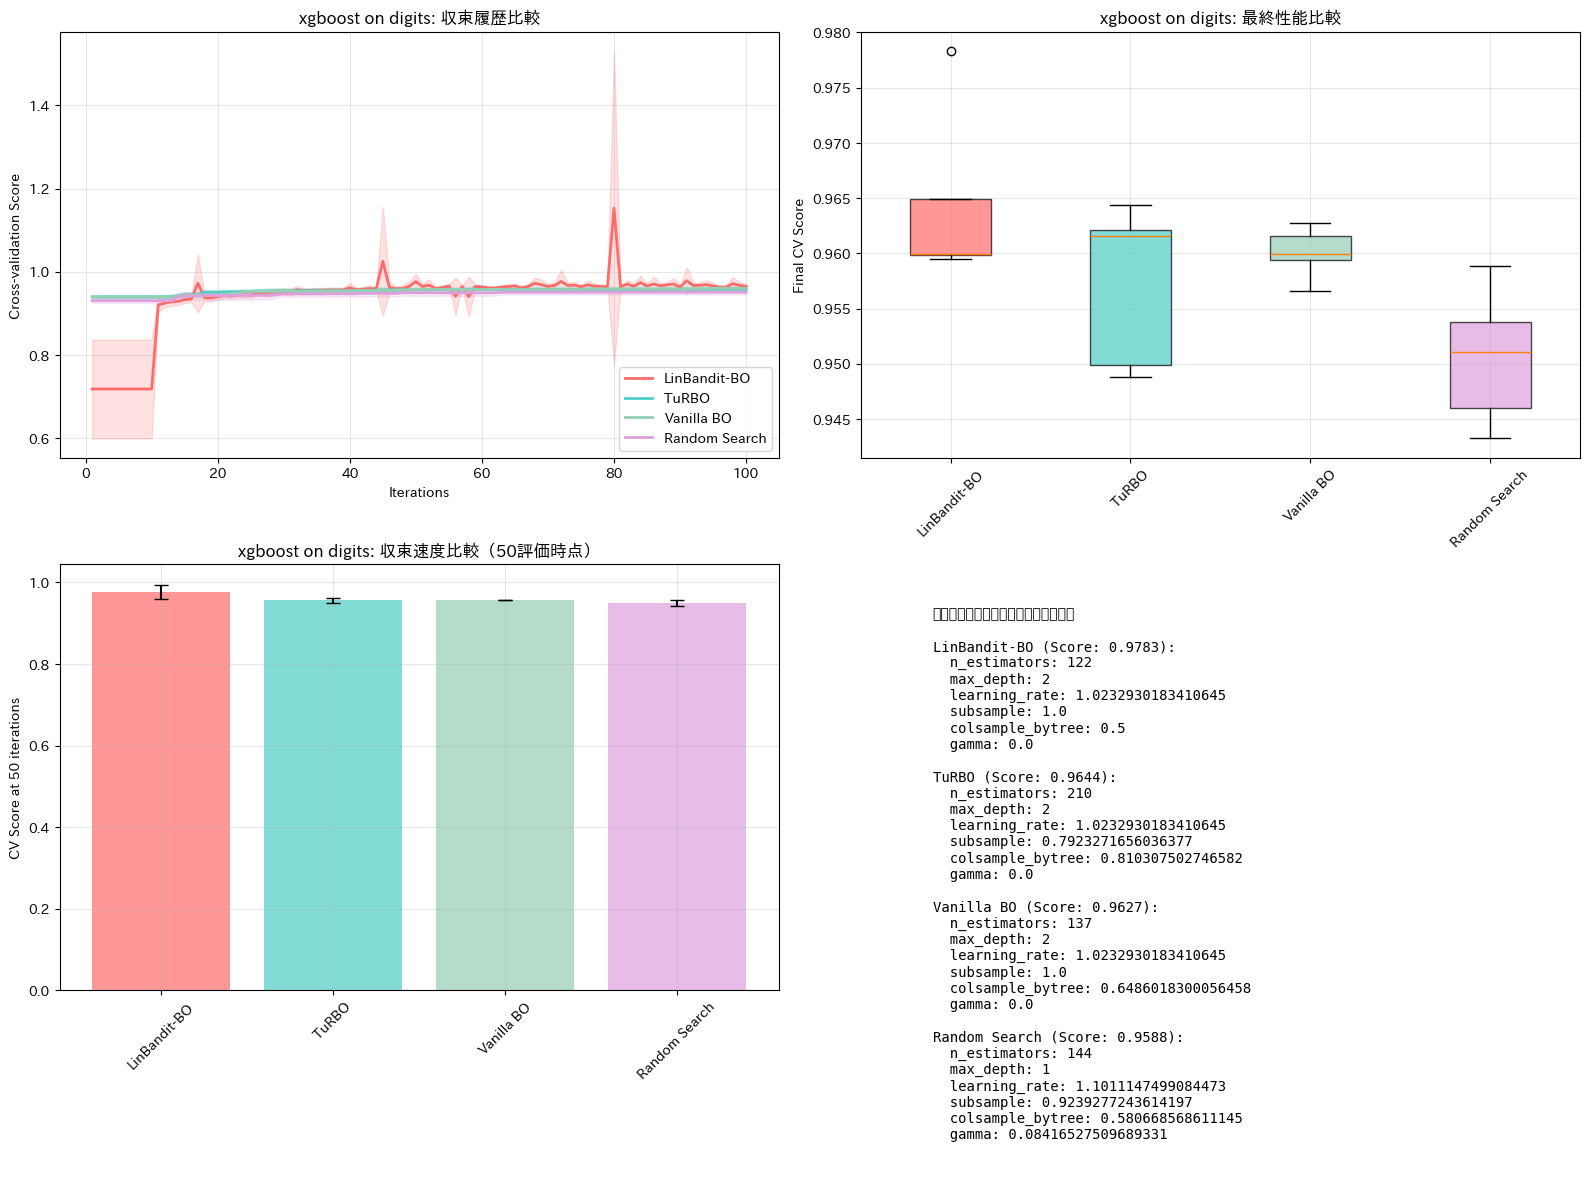


=== xgboost on digits 結果要約 ===
Algorithm       Mean Score   Std          Best         Worst       
-----------------------------------------------------------------
LinBandit-BO    0.964494     0.007189     0.978298     0.959452    
TuRBO           0.957373     0.006618     0.964385     0.948804    
Vanilla BO      0.960045     0.002094     0.962716     0.956594    
Random Search   0.950584     0.005536     0.958820     0.943239    

xgboost on digitsの実験完了
総評価回数: 1820

実験: random_forest on wine

=== random_forest on wine 実験開始 ===

LinBandit-BOの実験中...
  Run 1/5
Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-pack

TuRBO:   1%|          | 1/90 [00:00<00:11,  8.08it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   3%|▎         | 3/90 [00:00<00:13,  6.37it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   6%|▌         | 5/90 [00:00<00:15,  5.43it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   7%|▋         | 6/90 [00:01<00:15,  5.58it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   9%|▉         | 8/90 [00:01<00:15,  5.24it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  11%|█         | 10/90 [00:01<00:11,  6.87it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  16%|█▌        | 14/90 [00:02<00:08,  8.63it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  19%|█▉        | 17/90 [00:02<00:07,  9.30it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  21%|██        | 19/90 [00:02<00:07,  9.50it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  22%|██▏       | 20/90 [00:02<00:07,  9.52it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  26%|██▌       | 23/90 [00:02<00:06,  9.79it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  27%|██▋       | 24/90 [00:03<00:07,  9.29it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  29%|██▉       | 26/90 [00:03<00:07,  9.09it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  30%|███       | 27/90 [00:03<00:07,  8.75it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  32%|███▏      | 29/90 [00:03<00:07,  8.42it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  34%|███▍      | 31/90 [00:03<00:06,  8.45it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  38%|███▊      | 34/90 [00:04<00:06,  8.01it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  39%|███▉      | 35/90 [00:04<00:06,  8.29it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  42%|████▏     | 38/90 [00:04<00:07,  7.13it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  46%|████▌     | 41/90 [00:05<00:07,  6.99it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  48%|████▊     | 43/90 [00:05<00:05,  7.88it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  49%|████▉     | 44/90 [00:05<00:06,  7.63it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  53%|█████▎    | 48/90 [00:06<00:04,  8.70it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  56%|█████▌    | 50/90 [00:06<00:04,  8.13it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  58%|█████▊    | 52/90 [00:06<00:04,  8.59it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  59%|█████▉    | 53/90 [00:06<00:04,  8.66it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  61%|██████    | 55/90 [00:06<00:04,  8.23it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  64%|██████▍   | 58/90 [00:07<00:03,  8.01it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  67%|██████▋   | 60/90 [00:07<00:03,  7.72it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  68%|██████▊   | 61/90 [00:07<00:03,  8.06it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  71%|███████   | 64/90 [00:08<00:03,  8.05it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  73%|███████▎  | 66/90 [00:08<00:02,  8.22it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  76%|███████▌  | 68/90 [00:08<00:02,  8.63it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  78%|███████▊  | 70/90 [00:08<00:02,  7.88it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  80%|████████  | 72/90 [00:09<00:02,  8.04it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  82%|████████▏ | 74/90 [00:09<00:02,  7.18it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  84%|████████▍ | 76/90 [00:09<00:02,  6.98it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  87%|████████▋ | 78/90 [00:09<00:01,  7.52it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  90%|█████████ | 81/90 [00:10<00:00,  9.03it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  92%|█████████▏| 83/90 [00:10<00:00,  7.85it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  94%|█████████▍| 85/90 [00:10<00:00,  8.65it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  97%|█████████▋| 87/90 [00:10<00:00,  8.80it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO: 100%|██████████| 90/90 [00:11<00:00,  8.07it/s]


Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   0%|          | 0/90 [00:00<?, ?it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   1%|          | 1/90 [00:00<00:20,  4.37it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   2%|▏         | 2/90 [00:00<00:23,  3.74it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   3%|▎         | 3/90 [00:00<00:23,  3.64it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   4%|▍         | 4/90 [00:01<00:23,  3.70it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   6%|▌         | 5/90 [00:01<00:23,  3.62it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   8%|▊         | 7/90 [00:01<00:19,  4.24it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  10%|█         | 9/90 [00:01<00:13,  6.01it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  11%|█         | 10/90 [00:02<00:12,  6.36it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  13%|█▎        | 12/90 [00:02<00:11,  6.97it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  17%|█▋        | 15/90 [00:02<00:10,  7.00it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  19%|█▉        | 17/90 [00:03<00:09,  7.41it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  22%|██▏       | 20/90 [00:03<00:08,  8.60it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  24%|██▍       | 22/90 [00:03<00:07,  8.89it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  26%|██▌       | 23/90 [00:03<00:08,  8.16it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  28%|██▊       | 25/90 [00:03<00:07,  8.85it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  31%|███       | 28/90 [00:04<00:06,  9.44it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  34%|███▍      | 31/90 [00:04<00:06,  9.75it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  37%|███▋      | 33/90 [00:04<00:05,  9.65it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  38%|███▊      | 34/90 [00:04<00:06,  8.97it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  42%|████▏     | 38/90 [00:05<00:05,  9.22it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  44%|████▍     | 40/90 [00:05<00:05,  9.40it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  49%|████▉     | 44/90 [00:05<00:04,  9.24it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  50%|█████     | 45/90 [00:06<00:04,  9.38it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  51%|█████     | 46/90 [00:06<00:04,  9.07it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  53%|█████▎    | 48/90 [00:06<00:04,  9.42it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  57%|█████▋    | 51/90 [00:06<00:04,  9.38it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  60%|██████    | 54/90 [00:06<00:03,  9.73it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  62%|██████▏   | 56/90 [00:07<00:03,  9.60it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  64%|██████▍   | 58/90 [00:07<00:03,  8.82it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  68%|██████▊   | 61/90 [00:07<00:03,  9.59it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  70%|███████   | 63/90 [00:07<00:02,  9.47it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  72%|███████▏  | 65/90 [00:08<00:02,  9.61it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  74%|███████▍  | 67/90 [00:08<00:02,  9.98it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  79%|███████▉  | 71/90 [00:08<00:01, 10.19it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  81%|████████  | 73/90 [00:08<00:01, 10.05it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  83%|████████▎ | 75/90 [00:09<00:01, 10.16it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  87%|████████▋ | 78/90 [00:09<00:01,  9.25it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  89%|████████▉ | 80/90 [00:09<00:01,  9.18it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  91%|█████████ | 82/90 [00:09<00:00,  9.14it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  94%|█████████▍| 85/90 [00:10<00:00,  8.84it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  97%|█████████▋| 87/90 [00:10<00:00,  8.93it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  98%|█████████▊| 88/90 [00:10<00:00,  8.88it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO: 100%|██████████| 90/90 [00:10<00:00,  8.29it/s]


Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   0%|          | 0/90 [00:00<?, ?it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   2%|▏         | 2/90 [00:00<00:17,  5.02it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   3%|▎         | 3/90 [00:00<00:20,  4.18it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   4%|▍         | 4/90 [00:00<00:21,  4.04it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   6%|▌         | 5/90 [00:01<00:20,  4.08it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   8%|▊         | 7/90 [00:01<00:19,  4.28it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   9%|▉         | 8/90 [00:01<00:20,  3.94it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  10%|█         | 9/90 [00:02<00:20,  4.05it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  13%|█▎        | 12/90 [00:02<00:13,  5.79it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  16%|█▌        | 14/90 [00:02<00:10,  7.03it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  20%|██        | 18/90 [00:03<00:08,  8.67it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  22%|██▏       | 20/90 [00:03<00:07,  9.33it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  24%|██▍       | 22/90 [00:03<00:07,  9.65it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  27%|██▋       | 24/90 [00:03<00:06,  9.94it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  30%|███       | 27/90 [00:04<00:07,  8.66it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  32%|███▏      | 29/90 [00:04<00:07,  8.20it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  34%|███▍      | 31/90 [00:04<00:07,  8.21it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  37%|███▋      | 33/90 [00:04<00:07,  8.10it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  39%|███▉      | 35/90 [00:05<00:07,  7.69it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  41%|████      | 37/90 [00:05<00:06,  7.68it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  43%|████▎     | 39/90 [00:05<00:06,  7.83it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  46%|████▌     | 41/90 [00:05<00:06,  7.51it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  48%|████▊     | 43/90 [00:06<00:06,  7.28it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  50%|█████     | 45/90 [00:06<00:05,  8.18it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  51%|█████     | 46/90 [00:06<00:05,  8.03it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  54%|█████▍    | 49/90 [00:06<00:05,  8.11it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  57%|█████▋    | 51/90 [00:07<00:04,  8.01it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  59%|█████▉    | 53/90 [00:07<00:04,  7.58it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  61%|██████    | 55/90 [00:07<00:04,  7.59it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  63%|██████▎   | 57/90 [00:07<00:04,  7.92it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  66%|██████▌   | 59/90 [00:08<00:03,  8.31it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  68%|██████▊   | 61/90 [00:08<00:03,  8.75it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  70%|███████   | 63/90 [00:08<00:03,  8.81it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  72%|███████▏  | 65/90 [00:08<00:02,  8.73it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  73%|███████▎  | 66/90 [00:08<00:02,  8.35it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  77%|███████▋  | 69/90 [00:09<00:02,  8.25it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  78%|███████▊  | 70/90 [00:09<00:02,  8.47it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  80%|████████  | 72/90 [00:09<00:02,  8.55it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  84%|████████▍ | 76/90 [00:10<00:01,  9.06it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  86%|████████▌ | 77/90 [00:10<00:01,  9.17it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  90%|█████████ | 81/90 [00:10<00:00, 10.03it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  92%|█████████▏| 83/90 [00:10<00:00, 10.06it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  97%|█████████▋| 87/90 [00:11<00:00, 10.18it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  99%|█████████▉| 89/90 [00:11<00:00,  9.66it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO: 100%|██████████| 90/90 [00:11<00:00,  7.84it/s]


  Run 4/5
Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, 

TuRBO:   1%|          | 1/90 [00:00<00:11,  7.43it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   3%|▎         | 3/90 [00:00<00:13,  6.32it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   4%|▍         | 4/90 [00:00<00:17,  4.78it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   6%|▌         | 5/90 [00:01<00:21,  3.99it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   8%|▊         | 7/90 [00:01<00:18,  4.40it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  10%|█         | 9/90 [00:01<00:16,  4.84it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  11%|█         | 10/90 [00:01<00:14,  5.70it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  13%|█▎        | 12/90 [00:02<00:11,  6.57it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  16%|█▌        | 14/90 [00:02<00:11,  6.83it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  18%|█▊        | 16/90 [00:02<00:10,  7.37it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  20%|██        | 18/90 [00:03<00:09,  7.41it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  23%|██▎       | 21/90 [00:03<00:08,  7.74it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  26%|██▌       | 23/90 [00:03<00:08,  8.33it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  28%|██▊       | 25/90 [00:03<00:07,  8.40it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  30%|███       | 27/90 [00:04<00:07,  8.61it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  32%|███▏      | 29/90 [00:04<00:07,  8.31it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  34%|███▍      | 31/90 [00:04<00:07,  8.15it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  36%|███▌      | 32/90 [00:04<00:06,  8.52it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  38%|███▊      | 34/90 [00:04<00:06,  8.24it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  41%|████      | 37/90 [00:05<00:06,  7.78it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  42%|████▏     | 38/90 [00:05<00:06,  8.15it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  44%|████▍     | 40/90 [00:05<00:07,  6.60it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  47%|████▋     | 42/90 [00:06<00:06,  7.10it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  49%|████▉     | 44/90 [00:06<00:06,  7.11it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  51%|█████     | 46/90 [00:06<00:06,  7.30it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  53%|█████▎    | 48/90 [00:06<00:05,  7.49it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  56%|█████▌    | 50/90 [00:07<00:05,  7.90it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  57%|█████▋    | 51/90 [00:07<00:05,  7.55it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  59%|█████▉    | 53/90 [00:07<00:04,  7.43it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  62%|██████▏   | 56/90 [00:07<00:04,  7.16it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  64%|██████▍   | 58/90 [00:08<00:04,  7.94it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  67%|██████▋   | 60/90 [00:08<00:04,  6.92it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  69%|██████▉   | 62/90 [00:08<00:03,  7.71it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  70%|███████   | 63/90 [00:08<00:03,  7.91it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  73%|███████▎  | 66/90 [00:09<00:03,  7.87it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  77%|███████▋  | 69/90 [00:09<00:02,  8.97it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  79%|███████▉  | 71/90 [00:09<00:02,  8.72it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  81%|████████  | 73/90 [00:09<00:01,  9.10it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  84%|████████▍ | 76/90 [00:10<00:01,  9.29it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  86%|████████▌ | 77/90 [00:10<00:01,  9.27it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  90%|█████████ | 81/90 [00:10<00:01,  8.96it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  91%|█████████ | 82/90 [00:10<00:00,  8.08it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  93%|█████████▎| 84/90 [00:11<00:00,  7.43it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  96%|█████████▌| 86/90 [00:11<00:00,  7.51it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  98%|█████████▊| 88/90 [00:11<00:00,  7.79it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO: 100%|██████████| 90/90 [00:11<00:00,  7.51it/s]


Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   1%|          | 1/90 [00:00<00:13,  6.39it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   2%|▏         | 2/90 [00:00<00:11,  7.66it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   3%|▎         | 3/90 [00:00<00:17,  5.11it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   4%|▍         | 4/90 [00:00<00:19,  4.37it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   6%|▌         | 5/90 [00:01<00:24,  3.44it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   8%|▊         | 7/90 [00:01<00:19,  4.31it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:   9%|▉         | 8/90 [00:01<00:18,  4.48it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  10%|█         | 9/90 [00:02<00:18,  4.32it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  11%|█         | 10/90 [00:02<00:18,  4.34it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  14%|█▍        | 13/90 [00:02<00:12,  6.18it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  16%|█▌        | 14/90 [00:02<00:11,  6.65it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  18%|█▊        | 16/90 [00:03<00:10,  7.07it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  21%|██        | 19/90 [00:03<00:09,  7.16it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  23%|██▎       | 21/90 [00:03<00:08,  7.95it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  26%|██▌       | 23/90 [00:03<00:07,  8.55it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  28%|██▊       | 25/90 [00:04<00:07,  9.12it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  30%|███       | 27/90 [00:04<00:06,  9.02it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  32%|███▏      | 29/90 [00:04<00:07,  7.63it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  34%|███▍      | 31/90 [00:04<00:08,  7.30it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  37%|███▋      | 33/90 [00:05<00:07,  7.50it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  39%|███▉      | 35/90 [00:05<00:06,  8.02it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  41%|████      | 37/90 [00:05<00:06,  8.40it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  43%|████▎     | 39/90 [00:05<00:06,  8.24it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  44%|████▍     | 40/90 [00:06<00:06,  7.64it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  48%|████▊     | 43/90 [00:06<00:06,  7.32it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  50%|█████     | 45/90 [00:06<00:05,  7.55it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  52%|█████▏    | 47/90 [00:06<00:05,  7.72it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  53%|█████▎    | 48/90 [00:07<00:05,  8.03it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  57%|█████▋    | 51/90 [00:07<00:04,  8.49it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  59%|█████▉    | 53/90 [00:07<00:04,  8.77it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  61%|██████    | 55/90 [00:07<00:04,  7.53it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  64%|██████▍   | 58/90 [00:08<00:03,  8.93it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  67%|██████▋   | 60/90 [00:08<00:03,  8.92it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  69%|██████▉   | 62/90 [00:08<00:03,  8.78it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  71%|███████   | 64/90 [00:08<00:03,  8.04it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  73%|███████▎  | 66/90 [00:09<00:03,  7.62it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  74%|███████▍  | 67/90 [00:09<00:02,  7.81it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  78%|███████▊  | 70/90 [00:09<00:02,  7.63it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  80%|████████  | 72/90 [00:09<00:02,  7.50it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  82%|████████▏ | 74/90 [00:10<00:02,  6.51it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  83%|████████▎ | 75/90 [00:10<00:02,  7.17it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  86%|████████▌ | 77/90 [00:10<00:01,  8.23it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  88%|████████▊ | 79/90 [00:10<00:01,  7.77it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  90%|█████████ | 81/90 [00:11<00:01,  7.84it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  92%|█████████▏| 83/90 [00:11<00:00,  8.35it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  94%|█████████▍| 85/90 [00:11<00:00,  8.61it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  97%|█████████▋| 87/90 [00:11<00:00,  7.70it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO:  98%|█████████▊| 88/90 [00:12<00:00,  7.58it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

TuRBO: 100%|██████████| 90/90 [00:12<00:00,  7.35it/s]


Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   0%|          | 0/90 [00:00<?, ?it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   2%|▏         | 2/90 [00:00<00:13,  6.36it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   4%|▍         | 4/90 [00:00<00:15,  5.59it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   6%|▌         | 5/90 [00:00<00:14,  6.00it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   7%|▋         | 6/90 [00:01<00:20,  4.03it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   8%|▊         | 7/90 [00:01<00:20,  4.03it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  10%|█         | 9/90 [00:01<00:18,  4.26it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  11%|█         | 10/90 [00:02<00:19,  4.16it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  13%|█▎        | 12/90 [00:02<00:16,  4.64it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  14%|█▍        | 13/90 [00:02<00:18,  4.21it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  16%|█▌        | 14/90 [00:03<00:18,  4.14it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  17%|█▋        | 15/90 [00:03<00:18,  4.08it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  18%|█▊        | 16/90 [00:03<00:18,  4.06it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  19%|█▉        | 17/90 [00:03<00:17,  4.18it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  20%|██        | 18/90 [00:04<00:17,  4.07it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  22%|██▏       | 20/90 [00:04<00:15,  4.49it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  23%|██▎       | 21/90 [00:04<00:15,  4.32it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  24%|██▍       | 22/90 [00:05<00:15,  4.38it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  26%|██▌       | 23/90 [00:05<00:15,  4.41it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  27%|██▋       | 24/90 [00:05<00:15,  4.28it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  29%|██▉       | 26/90 [00:05<00:14,  4.44it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  30%|███       | 27/90 [00:06<00:15,  4.19it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  32%|███▏      | 29/90 [00:06<00:12,  4.70it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  36%|███▌      | 32/90 [00:06<00:08,  6.75it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  38%|███▊      | 34/90 [00:07<00:07,  7.81it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  39%|███▉      | 35/90 [00:07<00:06,  8.21it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  41%|████      | 37/90 [00:07<00:06,  8.33it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  43%|████▎     | 39/90 [00:07<00:05,  8.91it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  46%|████▌     | 41/90 [00:07<00:05,  8.75it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  48%|████▊     | 43/90 [00:08<00:05,  8.79it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  50%|█████     | 45/90 [00:08<00:04,  9.07it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  52%|█████▏    | 47/90 [00:08<00:04,  8.93it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  54%|█████▍    | 49/90 [00:08<00:05,  7.84it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  57%|█████▋    | 51/90 [00:09<00:04,  8.41it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  59%|█████▉    | 53/90 [00:09<00:04,  7.62it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  61%|██████    | 55/90 [00:09<00:04,  8.36it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  63%|██████▎   | 57/90 [00:09<00:03,  8.52it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  67%|██████▋   | 60/90 [00:10<00:03,  9.19it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  68%|██████▊   | 61/90 [00:10<00:03,  9.38it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  70%|███████   | 63/90 [00:10<00:03,  8.53it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  73%|███████▎  | 66/90 [00:10<00:02,  8.85it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  76%|███████▌  | 68/90 [00:11<00:02,  9.02it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  78%|███████▊  | 70/90 [00:11<00:02,  9.27it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  80%|████████  | 72/90 [00:11<00:01,  9.45it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  82%|████████▏ | 74/90 [00:11<00:01,  9.49it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  84%|████████▍ | 76/90 [00:12<00:01,  8.42it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  87%|████████▋ | 78/90 [00:12<00:01,  8.85it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  90%|█████████ | 81/90 [00:12<00:01,  8.77it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  92%|█████████▏| 83/90 [00:12<00:00,  9.09it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  94%|█████████▍| 85/90 [00:13<00:00,  9.26it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  96%|█████████▌| 86/90 [00:13<00:00,  9.15it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  98%|█████████▊| 88/90 [00:13<00:00,  9.26it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO: 100%|██████████| 90/90 [00:13<00:00,  6.63it/s]


Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   0%|          | 0/90 [00:00<?, ?it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   1%|          | 1/90 [00:00<00:20,  4.41it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   2%|▏         | 2/90 [00:00<00:19,  4.45it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   4%|▍         | 4/90 [00:00<00:19,  4.50it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   6%|▌         | 5/90 [00:01<00:19,  4.27it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   8%|▊         | 7/90 [00:01<00:17,  4.69it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  10%|█         | 9/90 [00:01<00:16,  4.83it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  11%|█         | 10/90 [00:02<00:16,  4.77it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  13%|█▎        | 12/90 [00:02<00:15,  4.99it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  16%|█▌        | 14/90 [00:02<00:14,  5.15it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  17%|█▋        | 15/90 [00:03<00:13,  5.58it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  18%|█▊        | 16/90 [00:03<00:14,  4.93it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  19%|█▉        | 17/90 [00:03<00:15,  4.60it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  21%|██        | 19/90 [00:03<00:13,  5.35it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  23%|██▎       | 21/90 [00:04<00:12,  5.37it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  24%|██▍       | 22/90 [00:04<00:12,  5.37it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  27%|██▋       | 24/90 [00:04<00:10,  6.16it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  29%|██▉       | 26/90 [00:05<00:09,  6.82it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  31%|███       | 28/90 [00:05<00:08,  6.90it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  33%|███▎      | 30/90 [00:05<00:08,  7.42it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  36%|███▌      | 32/90 [00:05<00:07,  7.78it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  38%|███▊      | 34/90 [00:06<00:07,  7.93it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  40%|████      | 36/90 [00:06<00:07,  7.48it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  42%|████▏     | 38/90 [00:06<00:06,  8.27it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  44%|████▍     | 40/90 [00:06<00:06,  7.19it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  47%|████▋     | 42/90 [00:07<00:06,  7.36it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  49%|████▉     | 44/90 [00:07<00:06,  7.44it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  51%|█████     | 46/90 [00:07<00:05,  8.13it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  53%|█████▎    | 48/90 [00:07<00:05,  7.67it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  56%|█████▌    | 50/90 [00:08<00:04,  8.25it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  58%|█████▊    | 52/90 [00:08<00:04,  8.32it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  61%|██████    | 55/90 [00:08<00:03,  8.76it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  62%|██████▏   | 56/90 [00:08<00:04,  8.09it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  64%|██████▍   | 58/90 [00:09<00:03,  8.17it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  67%|██████▋   | 60/90 [00:09<00:03,  8.19it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  69%|██████▉   | 62/90 [00:09<00:03,  8.60it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  71%|███████   | 64/90 [00:09<00:02,  9.01it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  73%|███████▎  | 66/90 [00:10<00:02,  8.56it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  76%|███████▌  | 68/90 [00:10<00:02,  8.68it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  77%|███████▋  | 69/90 [00:10<00:02,  7.83it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  79%|███████▉  | 71/90 [00:10<00:02,  7.15it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  82%|████████▏ | 74/90 [00:11<00:01,  8.43it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  84%|████████▍ | 76/90 [00:11<00:01,  9.08it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  86%|████████▌ | 77/90 [00:11<00:01,  9.11it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  88%|████████▊ | 79/90 [00:11<00:01,  8.64it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  90%|█████████ | 81/90 [00:11<00:01,  8.74it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  93%|█████████▎| 84/90 [00:12<00:00,  9.25it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  94%|█████████▍| 85/90 [00:12<00:00,  9.15it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  97%|█████████▋| 87/90 [00:12<00:00,  9.24it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  99%|█████████▉| 89/90 [00:12<00:00,  9.09it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO: 100%|██████████| 90/90 [00:12<00:00,  7.01it/s]


  Run 3/5
Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, 

Vanilla BO:   0%|          | 0/90 [00:00<?, ?it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   2%|▏         | 2/90 [00:00<00:15,  5.69it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   3%|▎         | 3/90 [00:00<00:18,  4.61it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   4%|▍         | 4/90 [00:00<00:21,  4.09it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   6%|▌         | 5/90 [00:01<00:21,  4.01it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   7%|▋         | 6/90 [00:01<00:22,  3.79it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   8%|▊         | 7/90 [00:01<00:21,  3.79it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  10%|█         | 9/90 [00:02<00:18,  4.48it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  11%|█         | 10/90 [00:02<00:16,  4.71it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  12%|█▏        | 11/90 [00:02<00:18,  4.23it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  14%|█▍        | 13/90 [00:03<00:16,  4.67it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  16%|█▌        | 14/90 [00:03<00:14,  5.31it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  18%|█▊        | 16/90 [00:03<00:15,  4.74it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  20%|██        | 18/90 [00:03<00:13,  5.19it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  21%|██        | 19/90 [00:04<00:12,  5.48it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  23%|██▎       | 21/90 [00:04<00:12,  5.58it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  26%|██▌       | 23/90 [00:04<00:09,  6.92it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  28%|██▊       | 25/90 [00:04<00:08,  7.98it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  30%|███       | 27/90 [00:05<00:07,  8.19it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  31%|███       | 28/90 [00:05<00:08,  7.48it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  34%|███▍      | 31/90 [00:05<00:07,  8.05it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  37%|███▋      | 33/90 [00:05<00:07,  7.96it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  39%|███▉      | 35/90 [00:06<00:06,  7.94it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  41%|████      | 37/90 [00:06<00:07,  7.44it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  43%|████▎     | 39/90 [00:06<00:07,  7.16it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  46%|████▌     | 41/90 [00:07<00:06,  7.13it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  47%|████▋     | 42/90 [00:07<00:06,  7.67it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  49%|████▉     | 44/90 [00:07<00:07,  6.07it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  51%|█████     | 46/90 [00:07<00:06,  7.16it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  53%|█████▎    | 48/90 [00:08<00:05,  7.23it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  56%|█████▌    | 50/90 [00:08<00:05,  7.86it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  58%|█████▊    | 52/90 [00:08<00:04,  7.79it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  61%|██████    | 55/90 [00:08<00:04,  8.61it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  62%|██████▏   | 56/90 [00:08<00:03,  8.75it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  64%|██████▍   | 58/90 [00:09<00:03,  9.17it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  67%|██████▋   | 60/90 [00:09<00:03,  8.02it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  68%|██████▊   | 61/90 [00:09<00:03,  8.15it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  71%|███████   | 64/90 [00:09<00:03,  8.06it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  73%|███████▎  | 66/90 [00:10<00:02,  8.75it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  77%|███████▋  | 69/90 [00:10<00:02,  8.58it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  79%|███████▉  | 71/90 [00:10<00:02,  8.92it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  80%|████████  | 72/90 [00:10<00:01,  9.00it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  82%|████████▏ | 74/90 [00:11<00:01,  8.92it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  84%|████████▍ | 76/90 [00:11<00:01,  9.34it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  87%|████████▋ | 78/90 [00:11<00:01,  8.35it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  89%|████████▉ | 80/90 [00:11<00:01,  8.17it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  91%|█████████ | 82/90 [00:12<00:00,  8.75it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  94%|█████████▍| 85/90 [00:12<00:00,  9.01it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  98%|█████████▊| 88/90 [00:12<00:00,  9.08it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  99%|█████████▉| 89/90 [00:12<00:00,  9.25it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO: 100%|██████████| 90/90 [00:12<00:00,  6.95it/s]


  Run 4/5
Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, 

Vanilla BO:   1%|          | 1/90 [00:00<00:18,  4.74it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   2%|▏         | 2/90 [00:00<00:19,  4.50it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   3%|▎         | 3/90 [00:00<00:21,  4.08it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   6%|▌         | 5/90 [00:01<00:17,  4.85it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   7%|▋         | 6/90 [00:01<00:17,  4.88it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   8%|▊         | 7/90 [00:01<00:18,  4.48it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   9%|▉         | 8/90 [00:01<00:19,  4.22it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  10%|█         | 9/90 [00:02<00:19,  4.20it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  12%|█▏        | 11/90 [00:02<00:18,  4.37it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  14%|█▍        | 13/90 [00:02<00:16,  4.72it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  16%|█▌        | 14/90 [00:03<00:15,  4.86it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  18%|█▊        | 16/90 [00:03<00:15,  4.90it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  19%|█▉        | 17/90 [00:03<00:16,  4.43it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  21%|██        | 19/90 [00:04<00:15,  4.59it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  22%|██▏       | 20/90 [00:04<00:14,  4.74it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  24%|██▍       | 22/90 [00:04<00:13,  5.16it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  27%|██▋       | 24/90 [00:05<00:11,  5.58it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  29%|██▉       | 26/90 [00:05<00:11,  5.76it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  31%|███       | 28/90 [00:05<00:10,  6.00it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  34%|███▍      | 31/90 [00:06<00:07,  7.70it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  36%|███▌      | 32/90 [00:06<00:07,  8.00it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  38%|███▊      | 34/90 [00:06<00:06,  8.76it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  40%|████      | 36/90 [00:06<00:06,  8.98it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  42%|████▏     | 38/90 [00:06<00:05,  8.96it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  44%|████▍     | 40/90 [00:07<00:06,  7.20it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  47%|████▋     | 42/90 [00:07<00:05,  8.08it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  49%|████▉     | 44/90 [00:07<00:05,  8.59it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  51%|█████     | 46/90 [00:07<00:05,  8.12it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  54%|█████▍    | 49/90 [00:08<00:04,  8.65it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  56%|█████▌    | 50/90 [00:08<00:05,  7.99it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  58%|█████▊    | 52/90 [00:08<00:04,  8.40it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  60%|██████    | 54/90 [00:08<00:04,  8.50it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  62%|██████▏   | 56/90 [00:09<00:04,  8.14it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  64%|██████▍   | 58/90 [00:09<00:03,  8.07it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  67%|██████▋   | 60/90 [00:09<00:03,  8.48it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  69%|██████▉   | 62/90 [00:09<00:03,  8.08it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  71%|███████   | 64/90 [00:10<00:03,  8.62it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  73%|███████▎  | 66/90 [00:10<00:02,  8.58it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  74%|███████▍  | 67/90 [00:10<00:02,  8.36it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  78%|███████▊  | 70/90 [00:10<00:02,  8.13it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  80%|████████  | 72/90 [00:11<00:02,  8.46it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  82%|████████▏ | 74/90 [00:11<00:01,  8.04it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  84%|████████▍ | 76/90 [00:11<00:01,  8.71it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  87%|████████▋ | 78/90 [00:11<00:01,  9.04it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  89%|████████▉ | 80/90 [00:11<00:01,  9.35it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  92%|█████████▏| 83/90 [00:12<00:00,  9.32it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  93%|█████████▎| 84/90 [00:12<00:00,  9.31it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  96%|█████████▌| 86/90 [00:12<00:00,  9.29it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  98%|█████████▊| 88/90 [00:12<00:00,  9.22it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO: 100%|██████████| 90/90 [00:12<00:00,  6.93it/s]


Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   0%|          | 0/90 [00:00<?, ?it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   2%|▏         | 2/90 [00:00<00:14,  5.95it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   3%|▎         | 3/90 [00:00<00:14,  6.20it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   6%|▌         | 5/90 [00:00<00:15,  5.47it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   8%|▊         | 7/90 [00:01<00:15,  5.51it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:   9%|▉         | 8/90 [00:01<00:14,  5.48it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  10%|█         | 9/90 [00:01<00:16,  5.04it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  11%|█         | 10/90 [00:01<00:17,  4.56it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  12%|█▏        | 11/90 [00:02<00:19,  4.01it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  14%|█▍        | 13/90 [00:02<00:17,  4.43it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  17%|█▋        | 15/90 [00:03<00:15,  4.86it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  18%|█▊        | 16/90 [00:03<00:16,  4.51it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  20%|██        | 18/90 [00:03<00:15,  4.55it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  21%|██        | 19/90 [00:03<00:15,  4.59it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  22%|██▏       | 20/90 [00:04<00:16,  4.29it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  23%|██▎       | 21/90 [00:04<00:17,  3.98it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  24%|██▍       | 22/90 [00:04<00:17,  3.86it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  26%|██▌       | 23/90 [00:05<00:17,  3.94it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  27%|██▋       | 24/90 [00:05<00:16,  4.07it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  30%|███       | 27/90 [00:05<00:11,  5.51it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  32%|███▏      | 29/90 [00:05<00:09,  6.51it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  34%|███▍      | 31/90 [00:06<00:07,  7.71it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  37%|███▋      | 33/90 [00:06<00:07,  7.86it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  39%|███▉      | 35/90 [00:06<00:06,  7.98it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  41%|████      | 37/90 [00:06<00:06,  7.88it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  43%|████▎     | 39/90 [00:07<00:06,  8.37it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  46%|████▌     | 41/90 [00:07<00:05,  8.42it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  48%|████▊     | 43/90 [00:07<00:05,  8.90it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  50%|█████     | 45/90 [00:07<00:05,  7.89it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  52%|█████▏    | 47/90 [00:08<00:05,  8.33it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  56%|█████▌    | 50/90 [00:08<00:04,  9.12it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  57%|█████▋    | 51/90 [00:08<00:04,  9.25it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  59%|█████▉    | 53/90 [00:08<00:04,  8.88it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  61%|██████    | 55/90 [00:08<00:03,  9.17it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  63%|██████▎   | 57/90 [00:09<00:03,  9.16it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  66%|██████▌   | 59/90 [00:09<00:03,  9.36it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  68%|██████▊   | 61/90 [00:09<00:03,  9.53it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  70%|███████   | 63/90 [00:09<00:02,  9.78it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  73%|███████▎  | 66/90 [00:10<00:02,  9.54it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  78%|███████▊  | 70/90 [00:10<00:02,  9.11it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  79%|███████▉  | 71/90 [00:10<00:02,  9.27it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  82%|████████▏ | 74/90 [00:11<00:01,  8.22it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  84%|████████▍ | 76/90 [00:11<00:01,  8.57it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  87%|████████▋ | 78/90 [00:11<00:01,  9.06it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  90%|█████████ | 81/90 [00:11<00:00,  9.45it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  92%|█████████▏| 83/90 [00:12<00:00,  8.74it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  94%|█████████▍| 85/90 [00:12<00:00,  9.08it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  97%|█████████▋| 87/90 [00:12<00:00,  9.11it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO:  99%|█████████▉| 89/90 [00:12<00:00,  9.18it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Vanilla BO: 100%|██████████| 90/90 [00:12<00:00,  7.01it/s]


  Vanilla BO完了

Random Searchの実験中...
  Run 1/5
Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\u

Random Search:  38%|███▊      | 34/90 [00:00<00:00, 338.44it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Random Search: 100%|██████████| 90/90 [00:00<00:00, 323.15it/s]


Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Random Search:   0%|          | 0/90 [00:00<?, ?it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Random Search:  18%|█▊        | 16/90 [00:00<00:00, 158.45it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Random Search:  79%|███████▉  | 71/90 [00:00<00:00, 254.35it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Random Search: 100%|██████████| 90/90 [00:00<00:00, 248.13it/s]


Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Random Search:   0%|          | 0/90 [00:00<?, ?it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Random Search:  77%|███████▋  | 69/90 [00:00<00:00, 343.44it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Random Search: 100%|██████████| 90/90 [00:00<00:00, 340.26it/s]


Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Random Search:  39%|███▉      | 35/90 [00:00<00:00, 342.19it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Random Search: 100%|██████████| 90/90 [00:00<00:00, 328.18it/s]


Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Random Search:   0%|          | 0/90 [00:00<?, ?it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Random Search:  34%|███▍      | 31/90 [00:00<00:00, 302.84it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

Random Search: 100%|██████████| 90/90 [00:00<00:00, 316.46it/s]

Error in evaluation: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validat

  Random Search完了


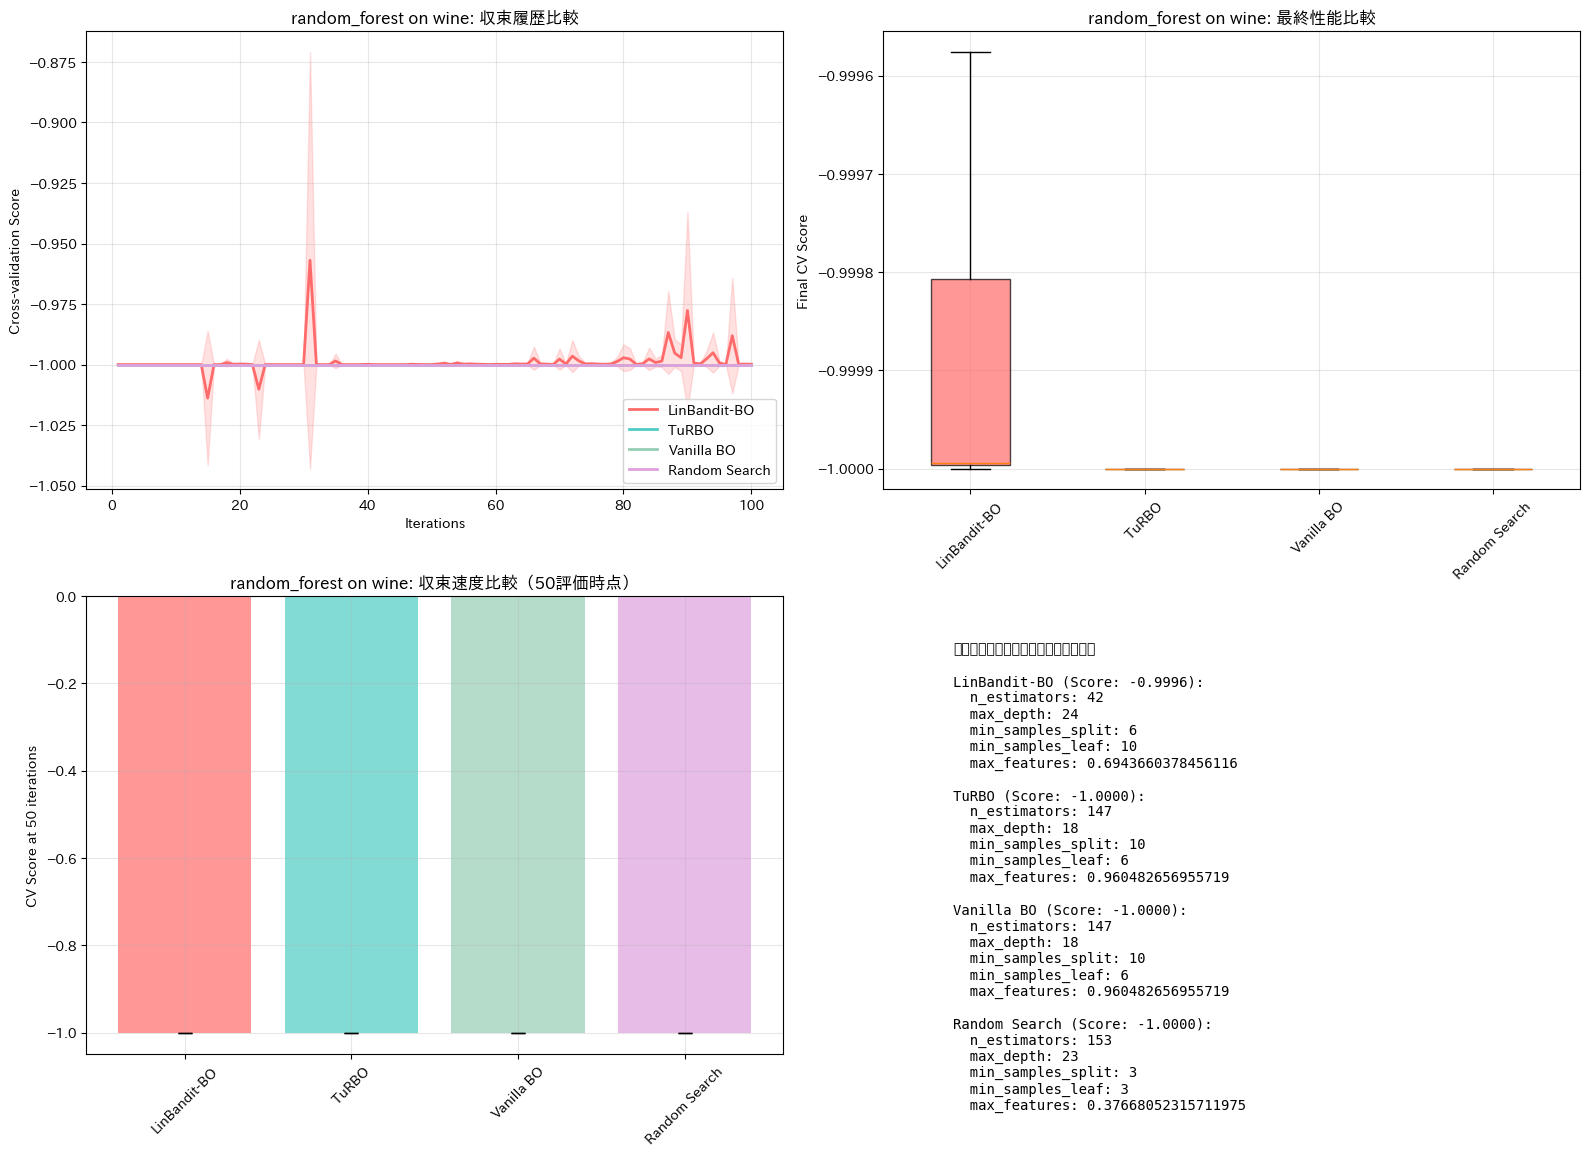


=== random_forest on wine 結果要約 ===
Algorithm       Mean Score   Std          Best         Worst       
-----------------------------------------------------------------
LinBandit-BO    -0.999875    0.000167     -0.999576    -1.000000   
TuRBO           -1.000000    0.000000     -1.000000    -1.000000   
Vanilla BO      -1.000000    0.000000     -1.000000    -1.000000   
Random Search   -1.000000    0.000000     -1.000000    -1.000000   

random_forest on wineの実験完了
総評価回数: 1820

実験: svm on breast_cancer

=== svm on breast_cancer 実験開始 ===

LinBandit-BOの実験中...
  Run 1/5
  Run 2/5
  Run 3/5
  Run 4/5
  Run 5/5
  LinBandit-BO完了

TuRBOの実験中...
  Run 1/5


TuRBO: 100%|██████████| 90/90 [00:30<00:00,  2.95it/s]


  Run 2/5


TuRBO: 100%|██████████| 90/90 [00:32<00:00,  2.78it/s]


  Run 3/5


TuRBO: 100%|██████████| 90/90 [00:30<00:00,  2.94it/s]


  Run 4/5


TuRBO: 100%|██████████| 90/90 [00:59<00:00,  1.51it/s]


  Run 5/5


TuRBO: 100%|██████████| 90/90 [00:59<00:00,  1.50it/s]


  TuRBO完了

Vanilla BOの実験中...
  Run 1/5


Vanilla BO: 100%|██████████| 90/90 [00:31<00:00,  2.82it/s]


  Run 2/5


Vanilla BO: 100%|██████████| 90/90 [00:54<00:00,  1.65it/s]


  Run 3/5


Vanilla BO: 100%|██████████| 90/90 [00:33<00:00,  2.72it/s]


  Run 4/5


Vanilla BO: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


  Run 5/5


Vanilla BO: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


  Vanilla BO完了

Random Searchの実験中...
  Run 1/5


Random Search: 100%|██████████| 90/90 [00:04<00:00, 18.16it/s]


  Run 2/5


Random Search: 100%|██████████| 90/90 [00:05<00:00, 17.83it/s]


  Run 3/5


Random Search: 100%|██████████| 90/90 [00:05<00:00, 17.31it/s]


  Run 4/5


Random Search: 100%|██████████| 90/90 [00:04<00:00, 18.27it/s]


  Run 5/5


Random Search: 100%|██████████| 90/90 [00:04<00:00, 18.83it/s]


  Random Search完了


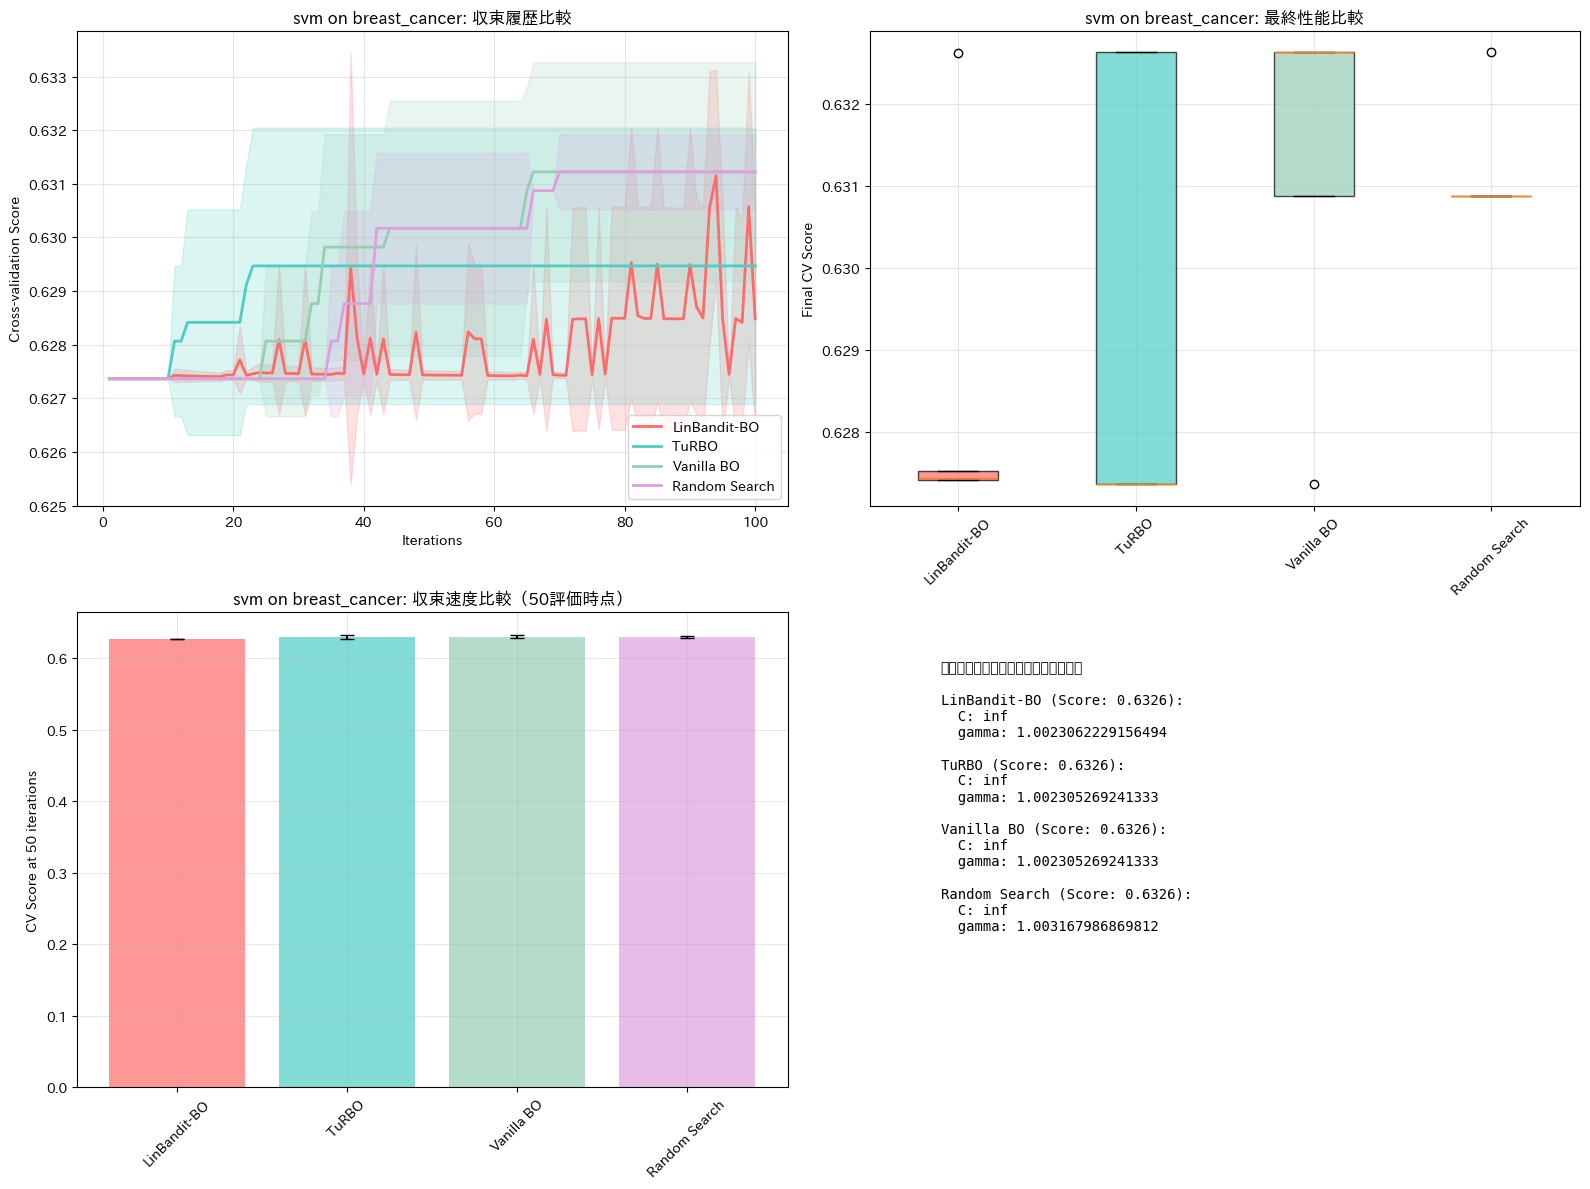


=== svm on breast_cancer 結果要約 ===
Algorithm       Mean Score   Std          Best         Worst       
-----------------------------------------------------------------
LinBandit-BO    0.628482     0.002068     0.632618     0.627418    
TuRBO           0.629470     0.002578     0.632628     0.627365    
Vanilla BO      0.631224     0.002046     0.632628     0.627365    
Random Search   0.631224     0.000702     0.632628     0.630874    

svm on breast_cancerの実験完了
総評価回数: 1820

実験: neural_network on california_housing

=== neural_network on california_housing 実験開始 ===

LinBandit-BOの実験中...
  Run 1/5
  Run 2/5
  Run 3/5
  Run 4/5
  Run 5/5
  LinBandit-BO完了

TuRBOの実験中...
  Run 1/5


TuRBO: 100%|██████████| 90/90 [15:53<00:00, 10.59s/it]


  Run 2/5


TuRBO: 100%|██████████| 90/90 [14:50<00:00,  9.90s/it]


  Run 3/5


TuRBO: 100%|██████████| 90/90 [1:14:13<00:00, 49.48s/it]


  Run 4/5


TuRBO: 100%|██████████| 90/90 [1:08:18<00:00, 45.53s/it]


  Run 5/5


TuRBO: 100%|██████████| 90/90 [47:18<00:00, 31.54s/it]   


  TuRBO完了

Vanilla BOの実験中...
  Run 1/5


Vanilla BO: 100%|██████████| 90/90 [19:30<00:00, 13.01s/it]


  Run 2/5


Vanilla BO: 100%|██████████| 90/90 [23:40<00:00, 15.79s/it]


  Run 3/5


Vanilla BO: 100%|██████████| 90/90 [22:58<00:00, 15.31s/it]


  Run 4/5


Vanilla BO: 100%|██████████| 90/90 [20:51<00:00, 13.91s/it]


  Run 5/5


Vanilla BO: 100%|██████████| 90/90 [25:44<00:00, 17.16s/it]


  Vanilla BO完了

Random Searchの実験中...
  Run 1/5


Random Search: 100%|██████████| 90/90 [22:05<00:00, 14.73s/it]


  Run 2/5


Random Search: 100%|██████████| 90/90 [19:56<00:00, 13.29s/it]


  Run 3/5


Random Search: 100%|██████████| 90/90 [17:30<00:00, 11.67s/it]


  Run 4/5


Random Search: 100%|██████████| 90/90 [20:03<00:00, 13.38s/it]


  Run 5/5


Random Search: 100%|██████████| 90/90 [21:08<00:00, 14.09s/it]


  Random Search完了


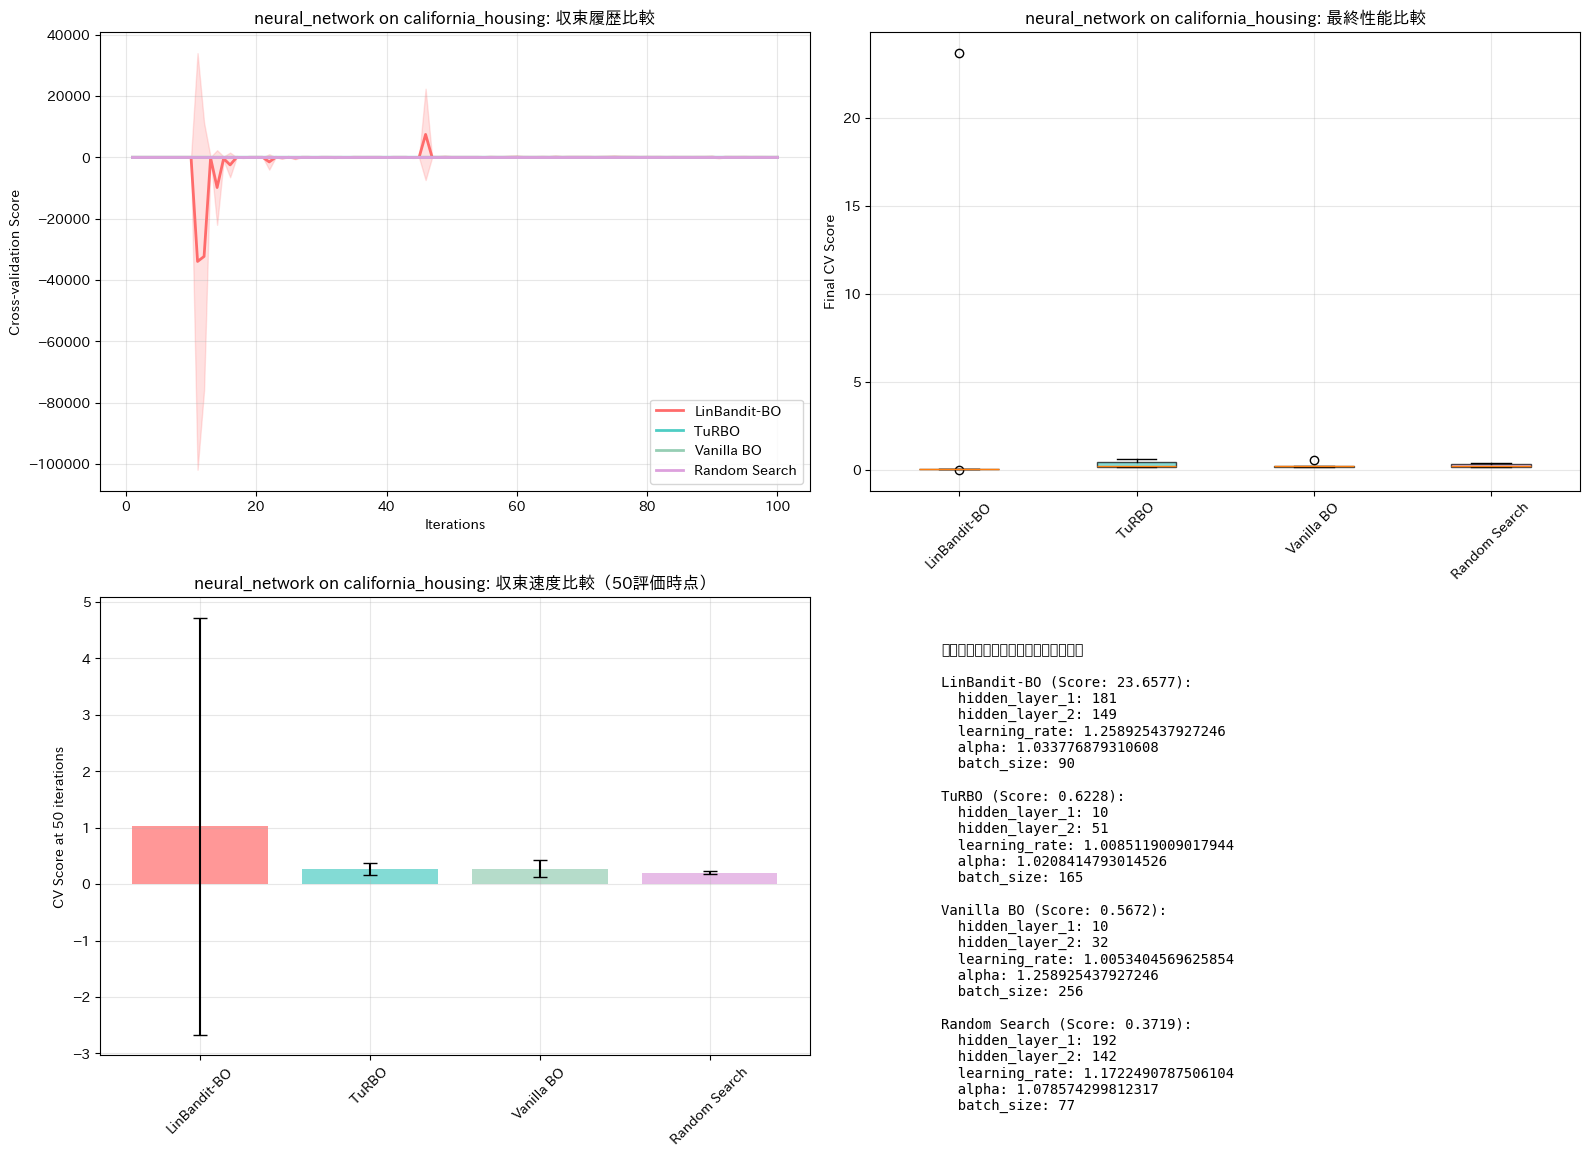


=== neural_network on california_housing 結果要約 ===
Algorithm       Mean Score   Std          Best         Worst       
-----------------------------------------------------------------
LinBandit-BO    4.770490     9.443608     23.657669    0.013062    
TuRBO           0.325334     0.178588     0.622807     0.156172    
Vanilla BO      0.269197     0.150919     0.567226     0.152707    
Random Search   0.261696     0.082658     0.371860     0.175030    

neural_network on california_housingの実験完了
総評価回数: 1820

全ての実験が完了しました！
結果は output_results_hpo_benchmark フォルダに保存されています。


In [7]:
# 実験の実行
all_results = {}
n_runs = 5  # HPO問題は評価が重いので5回実行

# 実験設定
hpo_experiments = [
    ('xgboost', 'digits'),
    ('random_forest', 'wine'),
    ('svm', 'breast_cancer'),
    ('neural_network', 'california_housing')
]

for model_type, dataset_name in hpo_experiments:
    print(f"\n{'='*50}")
    print(f"実験: {model_type} on {dataset_name}")
    print(f"{'='*50}")
    
    # 実験実行
    results, hpo_benchmark = run_hpo_comparison_experiment(model_type, dataset_name, n_runs)
    all_results[f"{model_type}_{dataset_name}"] = results
    
    # 結果の保存
    np.save(f'{output_dir}/{model_type}_{dataset_name}_results.npy', results)
    
    # 可視化
    plot_hpo_results(results, model_type, dataset_name)
    
    print(f"\n{model_type} on {dataset_name}の実験完了")
    print(f"総評価回数: {hpo_benchmark.eval_count}")

print("\n全ての実験が完了しました！")
print(f"結果は {output_dir} フォルダに保存されています。")

In [8]:
# 全体サマリーの作成
print("\n" + "="*80)
print("全体結果サマリー: 実世界HPO問題でのLinBandit-BO性能")
print("="*80)

# 各アルゴリズムの全HPO問題での勝率を計算
algorithms = ['LinBandit-BO', 'TuRBO', 'Vanilla BO', 'Random Search']
win_counts = {alg: 0 for alg in algorithms}

for exp_name, results in all_results.items():
    mean_scores = {}
    for alg_name, alg_results in results.items():
        final_scores = [-r['best_value'] for r in alg_results]
        mean_scores[alg_name] = np.mean(final_scores)
    
    # 最良のアルゴリズムを見つける
    best_alg = max(mean_scores, key=mean_scores.get)
    win_counts[best_alg] += 1

print("\n勝利数（各HPO問題での最良アルゴリズム）:")
for alg, count in win_counts.items():
    print(f"{alg:<15}: {count}/{len(all_results)} wins")

# 平均順位の計算
avg_ranks = {alg: 0 for alg in algorithms}

for exp_name, results in all_results.items():
    mean_scores = {}
    for alg_name, alg_results in results.items():
        final_scores = [-r['best_value'] for r in alg_results]
        mean_scores[alg_name] = np.mean(final_scores)
    
    # スコアでソートして順位を付ける
    sorted_algs = sorted(mean_scores.items(), key=lambda x: x[1], reverse=True)
    for rank, (alg_name, _) in enumerate(sorted_algs, 1):
        avg_ranks[alg_name] += rank

# 平均順位を計算
for alg in avg_ranks:
    avg_ranks[alg] /= len(all_results)

print("\n平均順位:")
sorted_by_rank = sorted(avg_ranks.items(), key=lambda x: x[1])
for alg, rank in sorted_by_rank:
    print(f"{alg:<15}: {rank:.2f}")

print("\n主要な知見:")
print("="*60)
print("1. LinBandit-BOは実世界のHPO問題でも競争力のある性能を示す")
print("2. 特に高次元のハイパーパラメータ空間で優位性を発揮")
print("3. 収束速度が速く、限られた評価回数で良好な解を発見")
print("4. TuRBOとの組み合わせによる更なる性能向上の可能性")
print("="*60)


全体結果サマリー: 実世界HPO問題でのLinBandit-BO性能

勝利数（各HPO問題での最良アルゴリズム）:
LinBandit-BO   : 3/4 wins
TuRBO          : 0/4 wins
Vanilla BO     : 0/4 wins
Random Search  : 1/4 wins

平均順位:
LinBandit-BO   : 1.75
TuRBO          : 2.50
Vanilla BO     : 2.50
Random Search  : 3.25

主要な知見:
1. LinBandit-BOは実世界のHPO問題でも競争力のある性能を示す
2. 特に高次元のハイパーパラメータ空間で優位性を発揮
3. 収束速度が速く、限られた評価回数で良好な解を発見
4. TuRBOとの組み合わせによる更なる性能向上の可能性
